In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import mplhep as hep

from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import awkward as ak

plt.style.use(hep.style.CMS)
plt.clf()
plt.close("all")

# ordered as [edgecolor, facecolor]
mainblue = ["#42719f", "#6ab4ff"]
coralgreen = ["#117a65", "#138D75"]
reddish = ["#c82929", "#e42f2f"]
orangish = ["#d78939", "#e48a2f"]
blueish = ["#4387cb", "#2f89e4"]

plt.rcParams["font.family"] = "Helvetica Neue"

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def PxPyPzE(v): # need this to be able to add four-vectors
    pt  = v[:,0:1]
    eta = v[:,1:2]
    phi = v[:,2:3]
    m   = v[:,3:4]
    
    Px, Py, Pz = pt*phi.cos(), pt*phi.sin(), pt*eta.sinh()
    E = (pt**2 + Pz**2 + m**2).sqrt()

    return torch.cat( (Px,Py,Pz,E), 1 )


def PtEtaPhiM(v):
    px = v[:,0:1]
    py = v[:,1:2]
    pz = v[:,2:3]
    e  = v[:,3:4]

    Pt  = (px**2+py**2).sqrt()
    ysign = py.sign()
    ysign = ysign + (ysign==0.0).float() # if py==0, px==Pt and acos(1)=pi/2 so we need zero protection on py.sign()
    Phi = (px/Pt).acos() * ysign
    Eta = (pz/Pt).asinh()

    M = F.relu(e**2 - px**2 - py**2 - pz**2).sqrt()

    return torch.cat( (Pt, Eta, Phi, M) , 1 ) 
    

## Load friend TTrees of the 3-fold model

In [3]:
train_region = 'preselection'
NanoAODSchema.warn_missing_crossrefs = False
fourTag_true = NanoEventsFactory.from_root(f'../../data/fourTag_picoAOD.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()
fourTag_rec = NanoEventsFactory.from_root(f'../../data/fourTag_dec.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()

In [100]:
fourTag_rec.dec.fields

['nJet',
 'Jet1_pt',
 'Jet1_eta',
 'Jet1_phi',
 'Jet1_mass',
 'Jet2_pt',
 'Jet2_eta',
 'Jet2_phi',
 'Jet2_mass',
 'Jet3_pt',
 'Jet3_eta',
 'Jet3_phi',
 'Jet3_mass',
 'Jet4_pt',
 'Jet4_eta',
 'Jet4_phi',
 'Jet4_mass']

## Jet $\eta$ with event rotation

Flip $\eta$

In [32]:
signEta = 1-2*(fourTag_true.Jet.eta[:, 0]<0)
eta_rot_true = fourTag_true.Jet.eta * signEta # flip first eta

signEta = 1-2*(fourTag_rec.dec.Jet1_eta[:]<0)
eta1_rot_rec = fourTag_rec.dec.Jet1_eta * signEta # flip first eta
eta2_rot_rec = fourTag_rec.dec.Jet2_eta * signEta # flip second eta
eta3_rot_rec = fourTag_rec.dec.Jet3_eta * signEta # flip third eta
eta4_rot_rec = fourTag_rec.dec.Jet4_eta * signEta # flip fourth eta

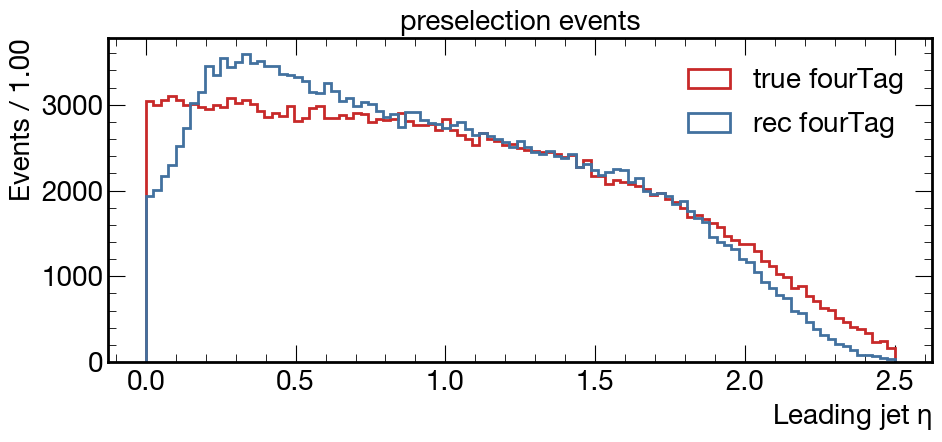

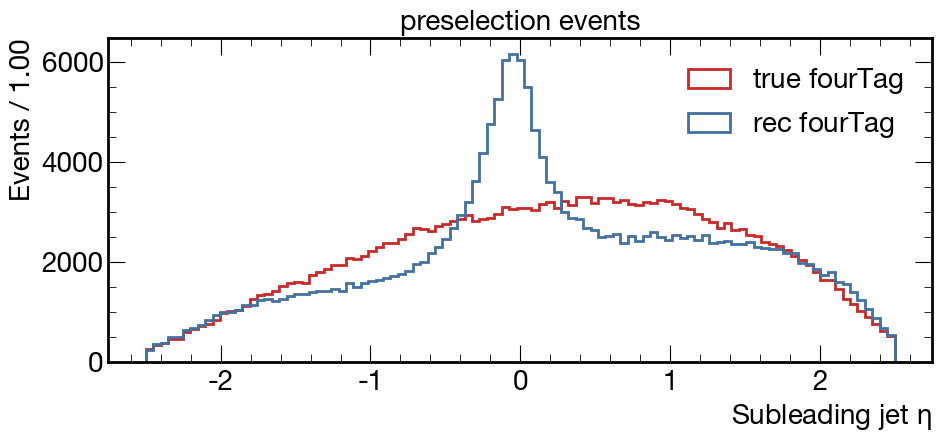

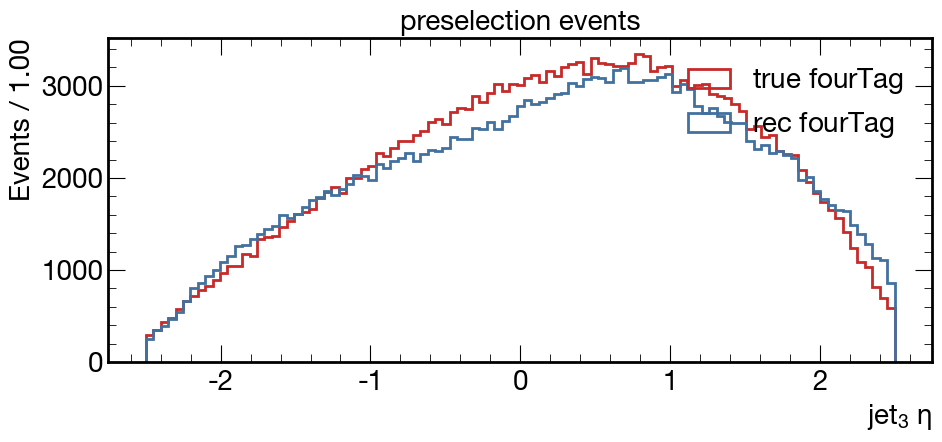

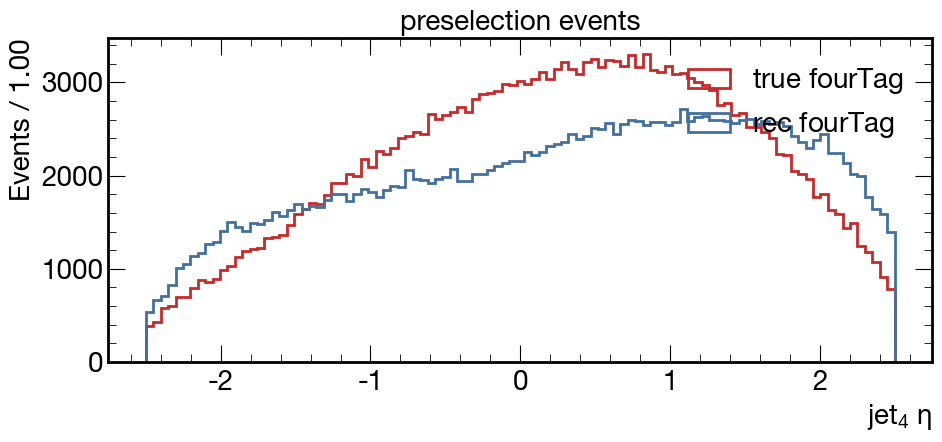

In [40]:
################################################################################################################################################################################################
# Leading jet eta #
################################################################################################################################################################################################
_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 0],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta1_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"Leading jet $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_leadingJet_eta.pdf")



################################################################################################################################################################################################
# Subleading jet eta #
################################################################################################################################################################################################

_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 1],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta2_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"Subleading jet $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_subleadingJet_eta.pdf")




################################################################################################################################################################################################
# Jet 3 eta #
################################################################################################################################################################################################

_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 2],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta3_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"jet$_{3}$ $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_Jet3_eta.pdf")




################################################################################################################################################################################################
# Jet 4 eta #
################################################################################################################################################################################################

_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 3],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta4_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"jet$_{4}$ $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_Jet4_eta.pdf")

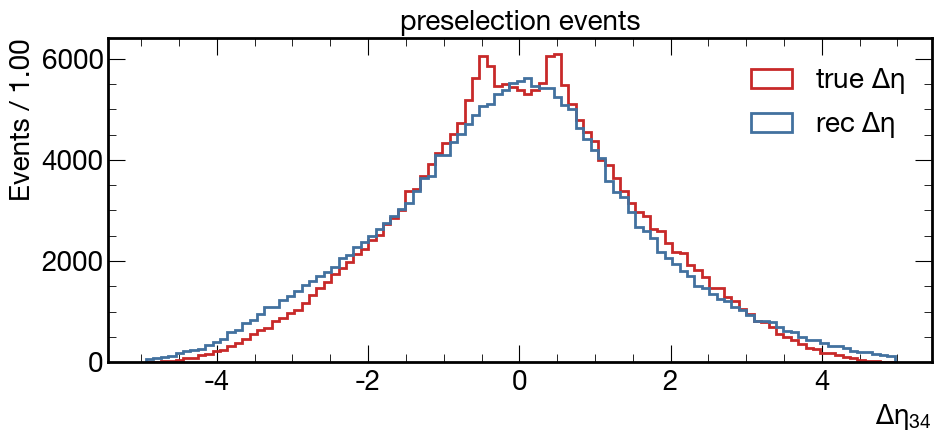

In [53]:
################################################################################################################################################################################################
# Leading jet eta #
################################################################################################################################################################################################
_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 2] - eta_rot_true[:, 3],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ \Delta \eta$"
)
h2, bins2, _ = ax.hist(
    eta3_rot_rec - eta4_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ \Delta \eta$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"$\Delta \eta_{34}$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_eta34.pdf")

## Jet $\eta$ without event rotation

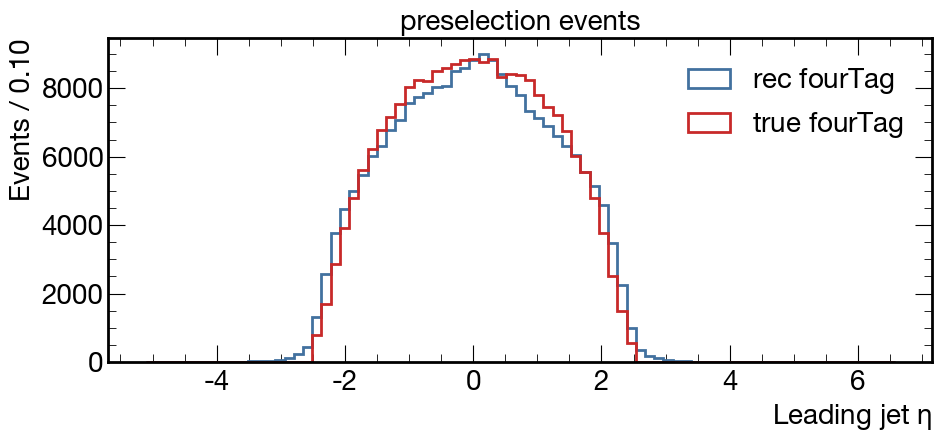

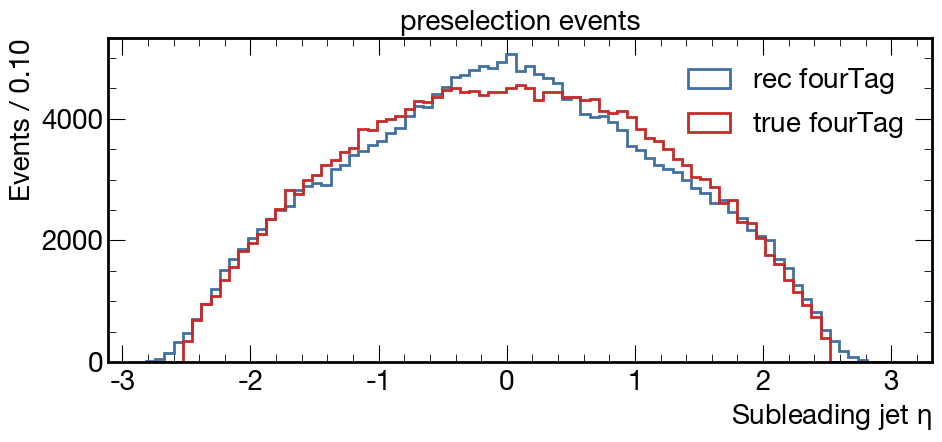

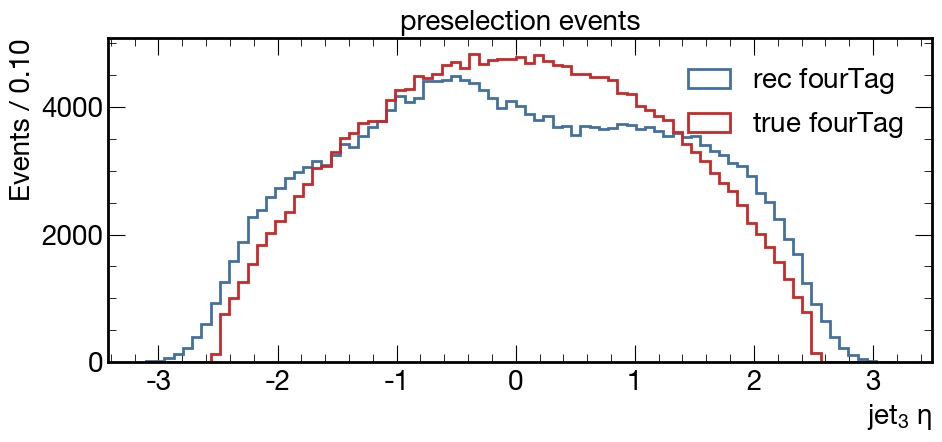

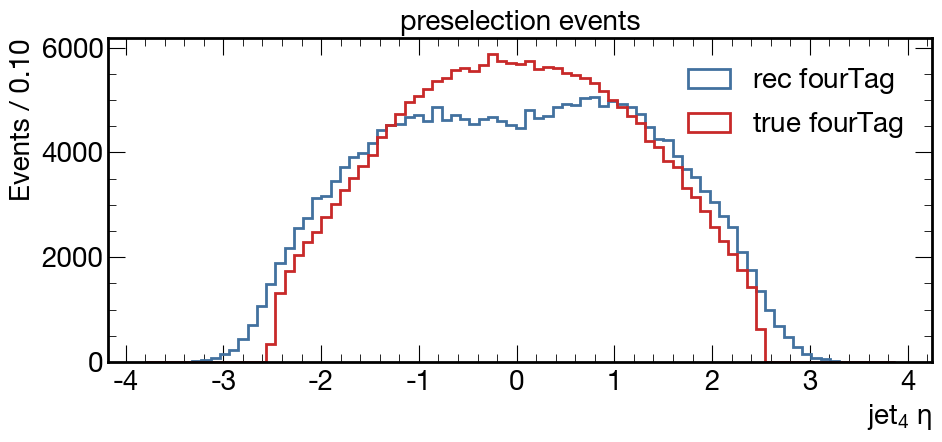

In [10]:
################################################################################################################################################################################################
# Leading jet eta #
################################################################################################################################################################################################
_min = -4.
_max = 4.
width = 0.1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    fourTag_rec.dec.Jet1_eta,
    bins = nbins,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)
h2, bins2, _ = ax.hist(
    fourTag_true.Jet.eta[:, 0],
    bins = bins1,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"Leading jet $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/noRotation_fourTag_dec_leadingJet_eta.pdf")



################################################################################################################################################################################################
# Subleading jet eta #
################################################################################################################################################################################################

_min = -4.
_max = 4.
width = 0.1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    fourTag_rec.dec.Jet2_eta,
    bins = nbins,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)
h2, bins2, _ = ax.hist(
    fourTag_true.Jet.eta[:, 1],
    bins = bins1,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"Subleading jet $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/noRotation_fourTag_dec_subleadingJet_eta.pdf")




################################################################################################################################################################################################
# Jet 3 eta #
################################################################################################################################################################################################

_min = -4.
_max = 4.
width = 0.1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    fourTag_rec.dec.Jet3_eta,
    bins = nbins,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)
h2, bins2, _ = ax.hist(
    fourTag_true.Jet.eta[:, 2],
    bins = bins1,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"jet$_{3}$ $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/noRotation_fourTag_dec_Jet3_eta.pdf")




################################################################################################################################################################################################
# Jet 4 eta #
################################################################################################################################################################################################

_min = -4.
_max = 4.
width = 0.1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    fourTag_rec.dec.Jet4_eta,
    bins = nbins,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)
h2, bins2, _ = ax.hist(
    fourTag_true.Jet.eta[:, 3],
    bins = bins1,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"jet$_{4}$ $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/noRotation_fourTag_dec_Jet4_eta.pdf")

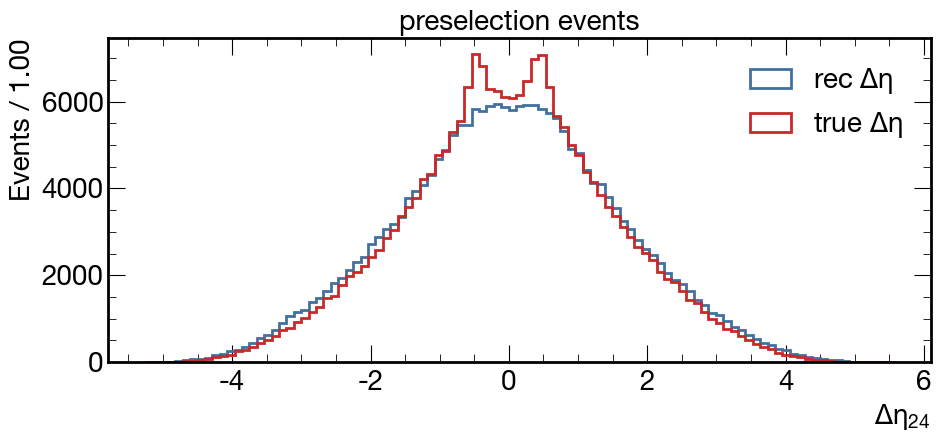

In [16]:
################################################################################################################################################################################################
# eta12 #
################################################################################################################################################################################################
_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    fourTag_rec.dec.Jet2_eta - fourTag_rec.dec.Jet4_eta,
    bins = nbins,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ \Delta \eta$"
)
h2, bins2, _ = ax.hist(
    fourTag_true.Jet.eta[:, 1] - fourTag_true.Jet.eta[:, 3],
    bins = bins1,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ \Delta \eta$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"$\Delta \eta_{24}$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/noRotation_fourTag_dec_eta24.pdf")

In [95]:
len(fourTag_true.Jet.eta[:, 2])

220151

In [122]:
pt = np.array(ak.flatten(fourTag_true.Jet.pt))
eta = np.array(ak.flatten(fourTag_true.Jet.eta))
phi = np.array(ak.flatten(fourTag_true.Jet.phi))
m = np.array(ak.flatten(fourTag_true.Jet.mass))
Px, Py, Pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)

(30.0, 250.0)

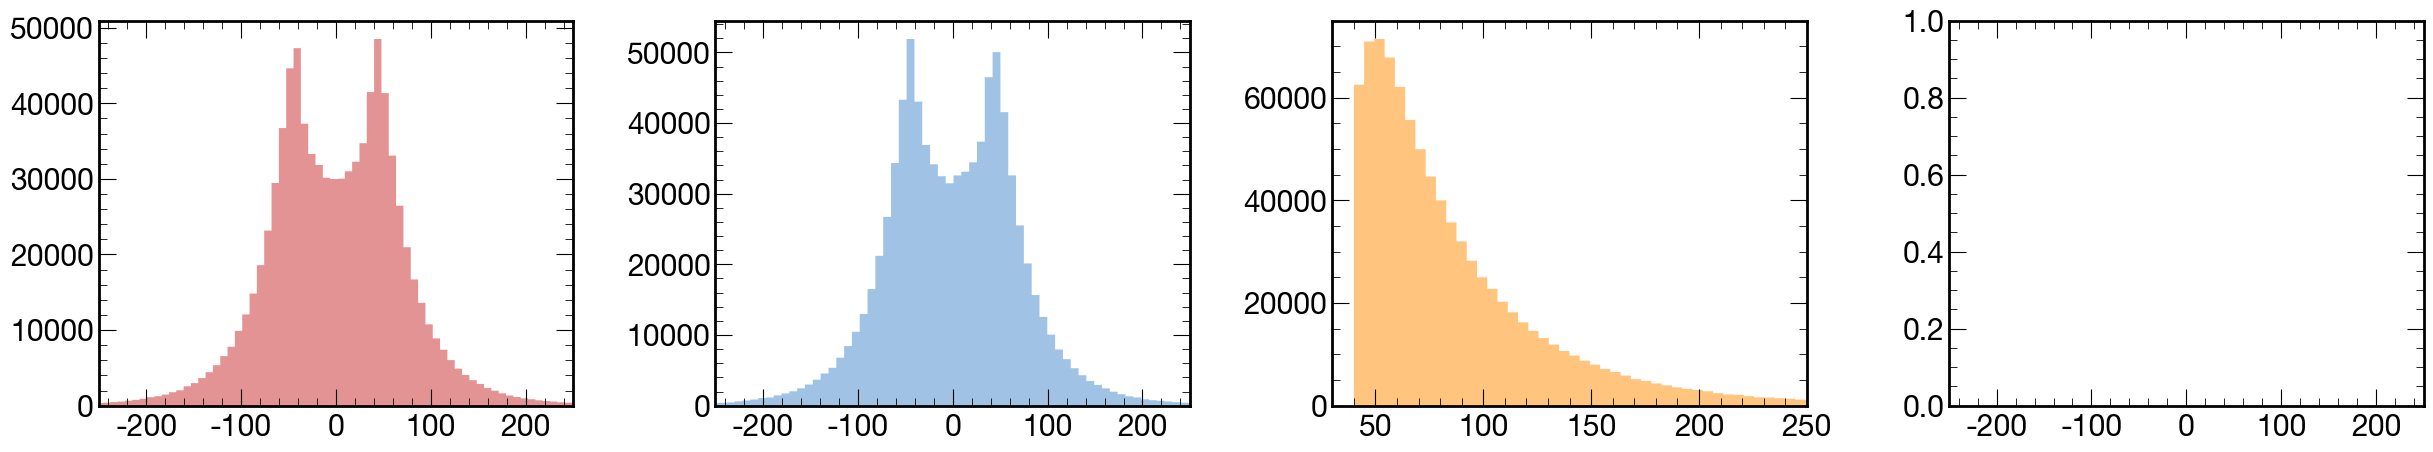

In [147]:
fig, ax = plt.subplots(1,4, figsize = (30,5))
ax[0].hist(Px, bins = 256, histtype = "stepfilled", alpha = 0.5, color = reddish[0])
ax[1].hist(Py, bins = 256, histtype = "stepfilled", alpha = 0.5, color = blueish[0])
ax[2].hist(pt, bins = 256, histtype = "stepfilled", alpha = 0.5, color = 'darkorange')

for a in ax:
    a.set_xlim(-250, 250)
ax[2].set_xlim(30, 250)

fig.subplots_adjust(wspace = 0.3)

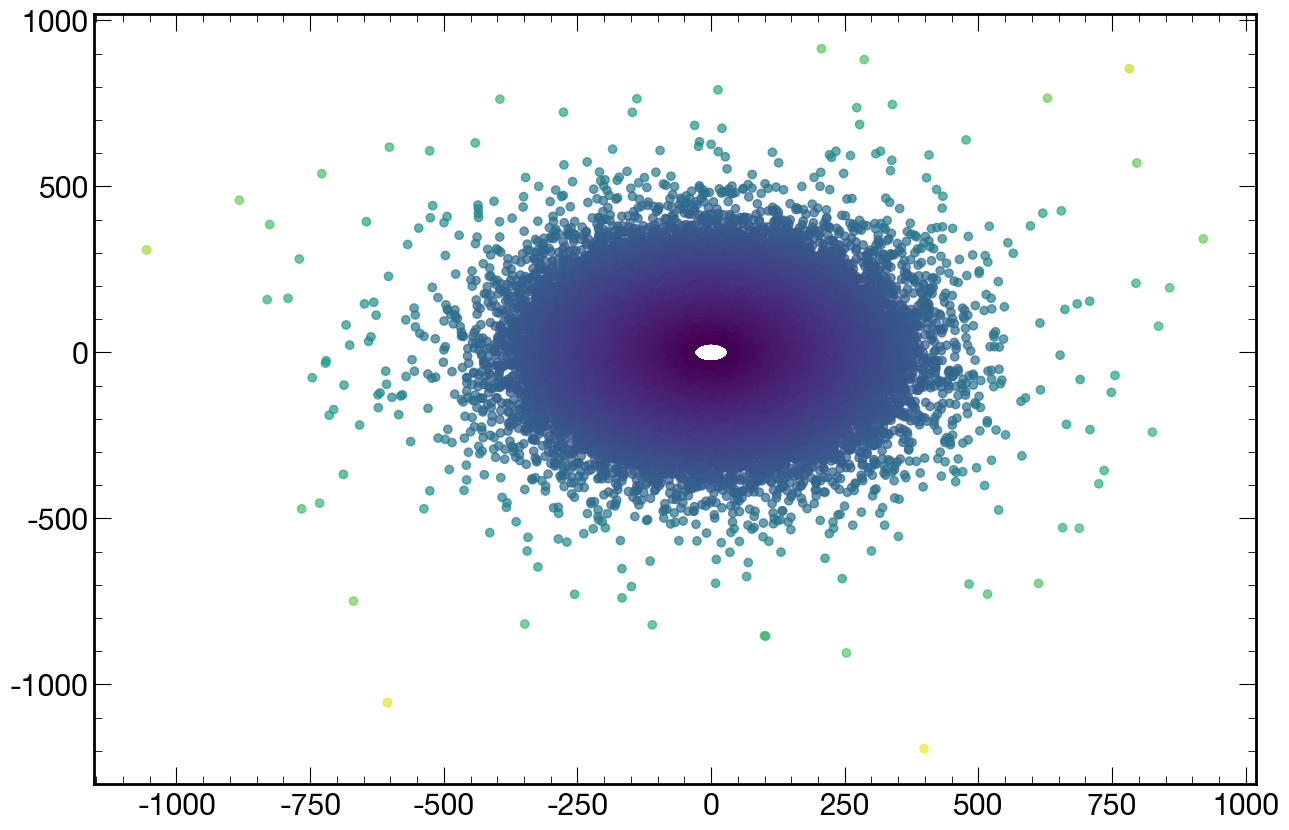

In [158]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
plt.scatter(Px, Py,
           linewidths=1, alpha=.7,
           edgecolor=None,
           c=pt)

(array([1.3985e+04, 1.4059e+04, 1.3969e+04, 1.4465e+04, 1.4471e+04,
        1.4971e+04, 1.5264e+04, 1.5779e+04, 1.6547e+04, 1.7801e+04,
        1.9949e+04, 2.3189e+04, 2.2368e+04, 2.1029e+04, 1.9127e+04,
        1.7281e+04, 1.5593e+04, 1.3868e+04, 1.2647e+04, 1.1311e+04,
        1.0158e+04, 9.1010e+03, 8.0300e+03, 7.4910e+03, 6.8030e+03,
        6.1180e+03, 5.3710e+03, 4.9750e+03, 4.5190e+03, 4.1030e+03,
        3.7900e+03, 3.4500e+03, 3.2540e+03, 2.8550e+03, 2.5530e+03,
        2.3940e+03, 2.1370e+03, 2.0000e+03, 1.8220e+03, 1.6120e+03,
        1.5610e+03, 1.4100e+03, 1.3230e+03, 1.1940e+03, 1.0910e+03,
        1.0090e+03, 9.5400e+02, 8.5500e+02, 7.6100e+02, 7.2400e+02,
        6.4800e+02, 5.9500e+02, 5.3600e+02, 5.3700e+02, 4.7000e+02,
        4.2800e+02, 4.3100e+02, 3.9800e+02, 3.5000e+02, 3.4200e+02,
        2.8800e+02, 2.9000e+02, 2.7100e+02, 2.4600e+02, 2.5200e+02,
        2.3300e+02, 1.8800e+02, 1.7100e+02, 1.9200e+02, 1.7400e+02,
        1.5300e+02, 1.3500e+02, 1.1600e+02, 1.34

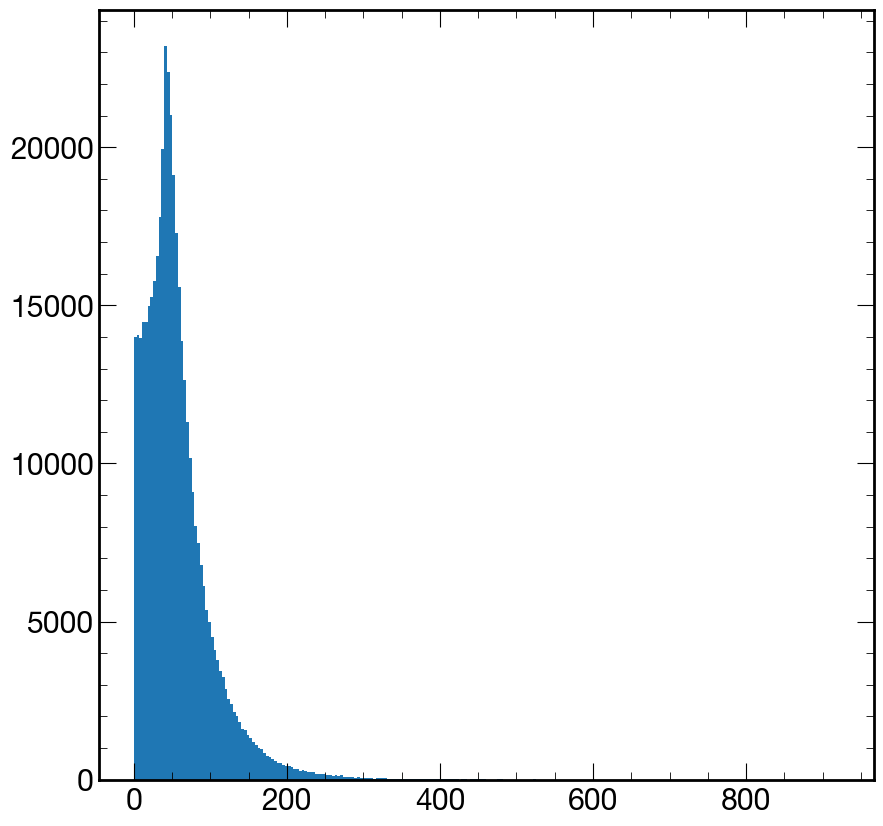

In [167]:
import torch.nn as nn
Pxpos = Px[Px>0]
plt.hist(Pxpos, bins = 256)

(array([2.1679e+04, 2.0471e+04, 1.9443e+04, 1.8662e+04, 1.7634e+04,
        1.7009e+04, 1.5919e+04, 1.4990e+04, 1.4544e+04, 1.3910e+04,
        1.3036e+04, 1.2504e+04, 1.1730e+04, 1.1173e+04, 1.0802e+04,
        1.0073e+04, 9.4960e+03, 9.3030e+03, 8.7500e+03, 8.3790e+03,
        7.8650e+03, 7.4620e+03, 7.1240e+03, 6.7610e+03, 6.5040e+03,
        6.3130e+03, 5.8470e+03, 5.5310e+03, 5.2650e+03, 5.0070e+03,
        4.7060e+03, 4.5550e+03, 4.4660e+03, 4.1930e+03, 3.9640e+03,
        3.7540e+03, 3.4980e+03, 3.3670e+03, 3.1150e+03, 3.1000e+03,
        2.8750e+03, 2.7330e+03, 2.6230e+03, 2.4550e+03, 2.4310e+03,
        2.1820e+03, 2.1940e+03, 2.0020e+03, 2.0610e+03, 1.8080e+03,
        1.7500e+03, 1.7260e+03, 1.5420e+03, 1.4770e+03, 1.4670e+03,
        1.3400e+03, 1.3260e+03, 1.2640e+03, 1.1140e+03, 1.1090e+03,
        1.0810e+03, 9.9600e+02, 9.1700e+02, 9.0700e+02, 8.9900e+02,
        7.4600e+02, 7.4700e+02, 7.3900e+02, 6.7300e+02, 6.7900e+02,
        6.1700e+02, 6.0800e+02, 5.9400e+02, 5.44

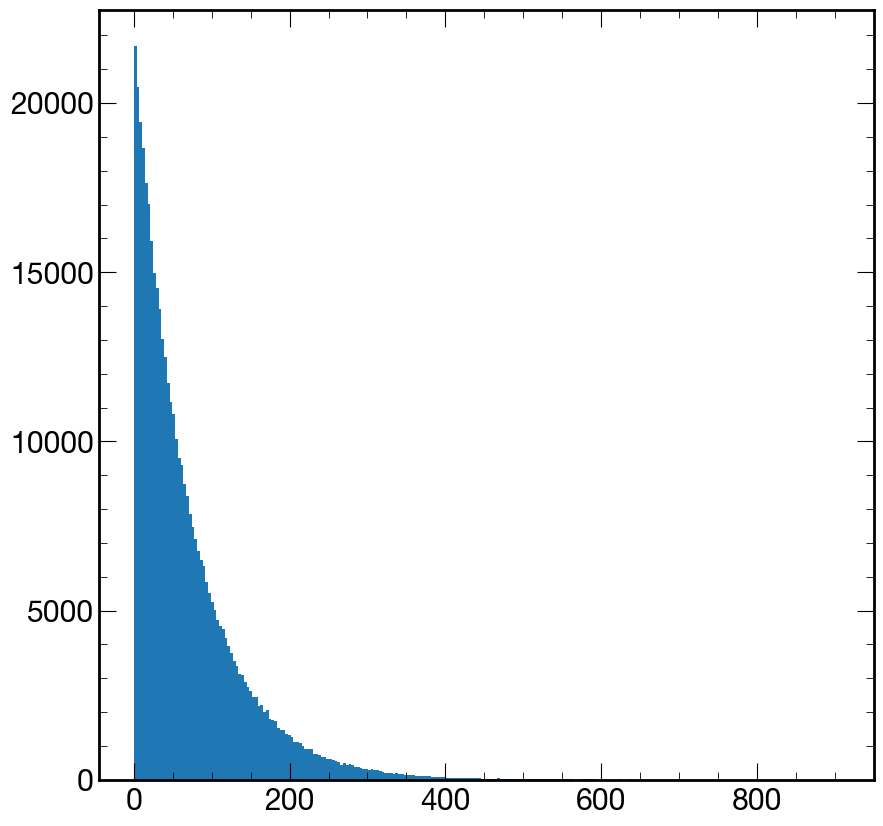

In [171]:
reco_Px = 700*np.random.exponential(0.1, size = (len(Pxpos)))
plt.hist(reco_Px, bins = 256)

In [183]:
Pxpos = torch.Tensor(Pxpos)
reco_Px = torch.Tensor(reco_Px)
print(F.binary_cross_entropy(Pxpos/ max(Pxpos), reco_Px / max(reco_Px)))

tensor(0.3040)


In [177]:
F.mse_loss(reco_Px, Pxpos)

tensor(7111.6919)